In [181]:
import cPickle as pickle
import pandas as pd
import numpy as np
import random 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score

import matplotlib
%matplotlib inline

In [22]:
def prep(df):

    # A few columns have to go for us to build a model (though we use them for user presentation)
    df.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
             'PassType', 'RushDirection', 'Yards', 'DefenseTeam'], axis=1, inplace=True)

    # create dummy variables for formations
    form_dummies = pd.get_dummies(df.Formation)
    form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

    # create dummy variables for teams
    team_dummies = pd.get_dummies(df.OffenseTeam)
    team_dummies.columns = map(lambda x: 'TEAM_' + str(x), team_dummies.columns)

    # combine the dummy variables and drop the categorical versions
    df_prepped = pd.concat(
        [df.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']],
        team_dummies,
        form_dummies], axis=1)

    return df_prepped

In [6]:
def combine(filenames):

    dfs = []
    for filename in filenames:
        dfs.append(pd.read_csv(filename))

    df = pd.concat(dfs)

    return df

In [9]:
def plot_confusion_matrix(cm):
    '''Code stolen brazenly from sklearn example.'''
    print(cm)

    # Show confusion matrix in a separate window
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Split off a validation set for the users and models to compete over

In [18]:
# read in the cleaned data, combine it, but leave it without dummies
filenames = ['data/pbp2016-clean.csv', 'data/pbp2015-clean.csv', 'data/pbp2014-clean.csv', 'data/pbp2013-clean.csv']
pbp_raw = combine(filenames)

In [19]:
pbp_train, pbp_validation = train_test_split(pbp_raw, test_size = 0.1) # 10% is about 13.5k plays

In [21]:
pbp_train.to_csv('data/pbp-training.csv')

In [20]:
pbp_validation.to_csv('data/pbp-validation.csv', index=False)

In [28]:
print 'training set:  ', pbp_train.shape
print 'validation set:', pbp_validation.shape

training set:   (121498, 17)
validation set: (13500, 17)


## Prep the training set

In [51]:
pbp_train_raw = pd.read_csv('data/pbp-training.csv')

In [25]:
pbp = prep(pbp_train_raw.copy())

In [29]:
# split the class from the values
y = pbp['Play']
X = pbp.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

### Basic Model Using All Seasons and All Teams

In [30]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [31]:
gbc.score(X_test, y_test)

0.77125925925925931

[[ 2871     1    12]
 [   10 13351  3540]
 [    3  3382  7205]]


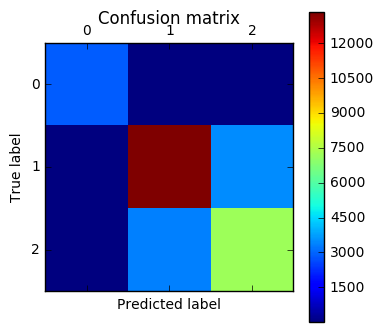

In [32]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

In [36]:
# save the model
with open('data/gbc-v2.pkl', 'w') as f:
    pickle.dump(gbc, f)

### Try putting in the season

In [39]:
df16 = pd.read_csv('data/pbp2016-clean.csv')
df15 = pd.read_csv('data/pbp2015-clean.csv')
df14 = pd.read_csv('data/pbp2014-clean.csv')
df13 = pd.read_csv('data/pbp2013-clean.csv')

In [40]:
df16['Season'] = 2016
df15['Season'] = 2015
df14['Season'] = 2014
df13['Season'] = 2013

In [41]:
df = pd.concat([df16, df15, df14, df13])

In [42]:
df_prepped = prep(df)

In [44]:
# split the class from the values
y = df_prepped['Play']
X = df_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [45]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [46]:
gbc.score(X_test, y_test)

0.76352592592592594

[[ 3150     3    12]
 [    6 14807  3999]
 [    7  3954  7812]]


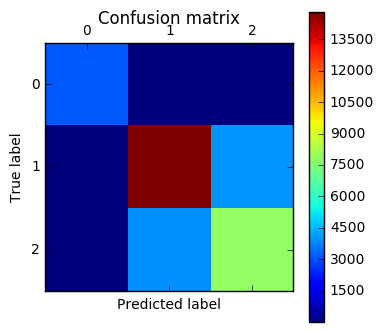

In [47]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### Tried this experiment without the 2016 data and it seems to make things worse

### Try losing the offense

In [64]:
df = pbp_train_raw.copy()

In [65]:
# A few columns have to go for us to build a model (though we use them for user presentation)
df.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards', 'DefenseTeam', 'OffenseTeam'], axis=1, inplace=True)

# create dummy variables for formations
form_dummies = pd.get_dummies(df.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

# combine the dummy variables and drop the categorical versions
df_prepped = pd.concat(
    [df.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']],
    form_dummies], axis=1)

In [66]:
df_prepped.head()

,Quarter,Minute,Second,Down,ToGo,YardLine,Play,FORMATION_FIELD_GOAL,FORMATION_NO_HUDDLE,FORMATION_NO_HUDDLE_SHOTGUN,FORMATION_PUNT,FORMATION_SHOTGUN,FORMATION_UNDER_CENTER,FORMATION_WILDCAT
0,2,0,29,1,10,1,RUSH,0,0,0,0,0,1,0
1,2,8,33,2,9,45,PASS,0,0,0,0,1,0,0
2,2,2,7,1,10,16,PASS,0,0,0,0,1,0,0
3,3,12,52,1,10,62,PASS,0,0,0,0,0,1,0
4,1,2,12,2,7,50,RUSH,0,0,0,0,0,1,0


In [67]:
# split the class from the values
y = df_prepped['Play']
X = df_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [68]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [69]:
gbc.score(X_test, y_test)

0.77040329218106995

[[ 2872     1    11]
 [   11 13416  3474]
 [    2  3475  7113]]


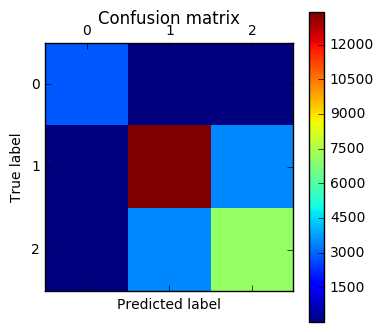

In [70]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### Very slight decline here; this should still be suitable for a prior "conventional wisdom" model

### Try keeping the defense in

In [74]:
df = pbp_train_raw.copy()

In [75]:
# A few columns have to go for us to build a model (though we use them for user presentation)
df.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards'], axis=1, inplace=True)

# create dummy variables for formations
form_dummies = pd.get_dummies(df.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

# create dummy variables for offensive teams
off_team_dummies = pd.get_dummies(df.OffenseTeam)
off_team_dummies.columns = map(lambda x: 'OFF_' + str(x), off_team_dummies.columns)

# create dummy variables for offensive teams
def_team_dummies = pd.get_dummies(df.DefenseTeam)
def_team_dummies.columns = map(lambda x: 'DEF_' + str(x), def_team_dummies.columns)

# combine the dummy variables and drop the categorical versions
df_prepped = pd.concat(
    [df.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']],
    off_team_dummies,
    def_team_dummies,
    form_dummies], axis=1)

In [76]:
df_prepped.columns

Index([u'Quarter', u'Minute', u'Second', u'Down', u'ToGo', u'YardLine',
       u'Play', u'OFF_ARI', u'OFF_ATL', u'OFF_BAL', u'OFF_BUF', u'OFF_CAR',
       u'OFF_CHI', u'OFF_CIN', u'OFF_CLE', u'OFF_DAL', u'OFF_DEN', u'OFF_DET',
       u'OFF_GB', u'OFF_HOU', u'OFF_IND', u'OFF_JAX', u'OFF_KC', u'OFF_LA',
       u'OFF_MIA', u'OFF_MIN', u'OFF_NE', u'OFF_NO', u'OFF_NYG', u'OFF_NYJ',
       u'OFF_OAK', u'OFF_PHI', u'OFF_PIT', u'OFF_SD', u'OFF_SEA', u'OFF_SF',
       u'OFF_TB', u'OFF_TEN', u'OFF_WAS', u'DEF_ARI', u'DEF_ATL', u'DEF_BAL',
       u'DEF_BUF', u'DEF_CAR', u'DEF_CHI', u'DEF_CIN', u'DEF_CLE', u'DEF_DAL',
       u'DEF_DEN', u'DEF_DET', u'DEF_GB', u'DEF_HOU', u'DEF_IND', u'DEF_JAX',
       u'DEF_KC', u'DEF_LA', u'DEF_MIA', u'DEF_MIN', u'DEF_NE', u'DEF_NO',
       u'DEF_NYG', u'DEF_NYJ', u'DEF_OAK', u'DEF_PHI', u'DEF_PIT', u'DEF_SD',
       u'DEF_SEA', u'DEF_SF', u'DEF_TB', u'DEF_TEN', u'DEF_WAS',
       u'FORMATION_FIELD_GOAL', u'FORMATION_NO_HUDDLE',
       u'FORMATION_NO_HUDDLE_SHOTG

In [77]:
# split the class from the values
y = df_prepped['Play']
X = df_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [78]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [79]:
gbc.score(X_test, y_test)

0.77158847736625513

[[ 2871     1    12]
 [   10 13373  3518]
 [    3  3394  7193]]


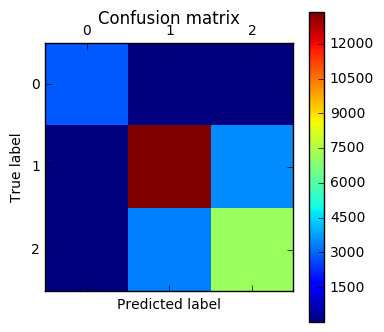

In [80]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### Very slight lift from using the defense; not enough to worry about

### Try using the no-offense model as a prior for another team-based model

#### Train a no-offense model

In [81]:
df = pbp_train_raw.copy()

In [82]:
# A few columns have to go for us to build a model (though we use them for user presentation)
df.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards', 'DefenseTeam', 'OffenseTeam'], axis=1, inplace=True)

# create dummy variables for formations
form_dummies = pd.get_dummies(df.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

# combine the dummy variables and drop the categorical versions
df_prepped = pd.concat(
    [df.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']],
    form_dummies], axis=1)

In [83]:
df_prepped.head()

,Quarter,Minute,Second,Down,ToGo,YardLine,Play,FORMATION_FIELD_GOAL,FORMATION_NO_HUDDLE,FORMATION_NO_HUDDLE_SHOTGUN,FORMATION_PUNT,FORMATION_SHOTGUN,FORMATION_UNDER_CENTER,FORMATION_WILDCAT
0,2,0,29,1,10,1,RUSH,0,0,0,0,0,1,0
1,2,8,33,2,9,45,PASS,0,0,0,0,1,0,0
2,2,2,7,1,10,16,PASS,0,0,0,0,1,0,0
3,3,12,52,1,10,62,PASS,0,0,0,0,0,1,0
4,1,2,12,2,7,50,RUSH,0,0,0,0,0,1,0


In [84]:
# split the class from the values
y = df_prepped['Play']
X = df_prepped.drop(['Play'], axis=1).values

In [85]:
# gradient boosting classifier
gbc_cw = GradientBoostingClassifier()
gbc_cw.fit(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

#### we want to add 3 columns to the original dataframe: PROB_PASS, PROB_RUSH, PROB_KICK

In [89]:
def get_probas(record):
    
    '''
    This takes a dataframe and puts it in the format the conventional wisdom model expects.
    '''

    formations = [
    'FIELD_GOAL',
    'NO_HUDDLE',
    'NO_HUDDLE_SHOTGUN',
    'PUNT',
    'SHOTGUN',
    'UNDER_CENTER',
    'WILDCAT']


    # Dummy the formation
    df1 = pd.get_dummies(record.Formation)
    dummies_frame = pd.get_dummies(formations)
    df1 = df1.reindex(columns=dummies_frame.columns, fill_value=0)
    df1.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), df1.columns)

    # Combine the dummy variables and drop the categorical versions
    record = pd.concat(
        [record.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']],
        df1], axis=1)
    
    # split the class from the values and run it through the model
    return gbc_cw.predict_proba(record.drop(['Play'], axis=1).values)

#### try out the procedure on one record

In [121]:
df_new = pbp_train_raw.copy()

In [98]:
# pick a random play out of the data
rand_play = pd.DataFrame(df_new.iloc[random.randint(0,df_new.shape[0])]).T

In [100]:
get_probas(rand_play)[0] # [kick, pass, rush]

array([  2.57920670e-04,   7.67674490e-01,   2.32067589e-01])

#### apply it to the whole dataframe

In [122]:
probas = get_probas(df_new)

In [123]:
df_new['PROB_KICK'] = probas[:,0]
df_new['PROB_PASS'] = probas[:,1]
df_new['PROB_RUSH'] = probas[:,2]

In [124]:
df_new.iloc[random.randint(0,df_new.shape[0])]

Unnamed: 0                                                       33671
Quarter                                                              2
Minute                                                               4
Second                                                               5
OffenseTeam                                                        NYJ
DefenseTeam                                                        MIA
Down                                                                 3
ToGo                                                                 2
YardLine                                                            94
Description          (4:05) (SHOTGUN) 7-G.SMITH RIGHT TACKLE TO MIA...
Yards                                                                5
Formation                                                      SHOTGUN
PlayType                                                          RUSH
PassType                                                           NaN
RushDi

#### now, dummy out the teams and formations and train a new model

In [125]:
# A few columns have to go for us to build a model (though we use them for user presentation)
df_new.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards', 'DefenseTeam'], axis=1, inplace=True)

# create dummy variables for formations
form_dummies = pd.get_dummies(df_new.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

# create dummy variables for teams
team_dummies = pd.get_dummies(df_new.OffenseTeam)
team_dummies.columns = map(lambda x: 'TEAM_' + str(x), team_dummies.columns)

# combine the dummy variables and drop the categorical versions
df_new_prepped = pd.concat(
    [df_new.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'PROB_KICK','PROB_PASS','PROB_RUSH', 'Play']],
    team_dummies,
    form_dummies], axis=1)

In [127]:
df_new_prepped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121498 entries, 0 to 121497
Data columns (total 49 columns):
Quarter                        121498 non-null int64
Minute                         121498 non-null int64
Second                         121498 non-null int64
Down                           121498 non-null int64
ToGo                           121498 non-null int64
YardLine                       121498 non-null int64
PROB_KICK                      121498 non-null float64
PROB_PASS                      121498 non-null float64
PROB_RUSH                      121498 non-null float64
Play                           121498 non-null object
TEAM_ARI                       121498 non-null uint8
TEAM_ATL                       121498 non-null uint8
TEAM_BAL                       121498 non-null uint8
TEAM_BUF                       121498 non-null uint8
TEAM_CAR                       121498 non-null uint8
TEAM_CHI                       121498 non-null uint8
TEAM_CIN                       121

In [128]:
# split the class from the values
y = df_new_prepped['Play']
X = df_new_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [129]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [130]:
gbc.score(X_test, y_test)

0.77254320987654324

[[ 2873     1    10]
 [   10 13381  3510]
 [    3  3375  7212]]


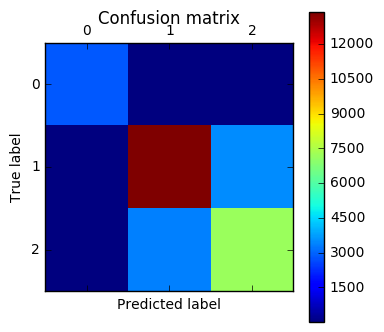

In [131]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### This shows a .15% improvement, which is nominal.  Formation went into the prior model... it probably shouldn't have, since that decision is offense-specific.

### Try again, but leave formation out of the prior model.

In [141]:
df = pbp_train_raw.copy()

In [142]:
# A few columns have to go for us to build a model (though we use them for user presentation)
df.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards', 'DefenseTeam', 'OffenseTeam', \
         'Formation', 'Unnamed: 0'], axis=1, inplace=True)

In [143]:
df.head()

,Quarter,Minute,Second,Down,ToGo,YardLine,Play
0,2,0,29,1,10,1,RUSH
1,2,8,33,2,9,45,PASS
2,2,2,7,1,10,16,PASS
3,3,12,52,1,10,62,PASS
4,1,2,12,2,7,50,RUSH


In [153]:
# split the class from the values
y = df['Play']
X = df.drop(['Play'], axis=1).values

In [154]:
# gradient boosting classifier
gbc_cw = GradientBoostingClassifier()
gbc_cw.fit(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

#### we want to add 3 columns to the original dataframe: PROB_PASS, PROB_RUSH, PROB_KICK

In [155]:
def get_probas(record):
    
    # A few columns have to go for us to build a model (though we use them for user presentation)
    record.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards', 'DefenseTeam', 'OffenseTeam', \
         'Formation', 'Unnamed: 0'], axis=1, inplace=True)
    
    # split the class from the values and run it through the model
    return gbc_cw.predict_proba(record.drop(['Play'], axis=1).values)

#### try out the procedure on one record

In [162]:
df_new = pbp_train_raw.copy()

In [163]:
# pick a random play out of the data
rand_play = pd.DataFrame(df_new.iloc[random.randint(0,df_new.shape[0])]).T

In [158]:
get_probas(rand_play)[0] # [kick, pass, rush]

array([ 0.00110132,  0.31112659,  0.6877721 ])

#### apply it to the whole dataframe

In [164]:
probas = get_probas(df_new.copy())

In [165]:
df_new['PROB_KICK'] = probas[:,0]
df_new['PROB_PASS'] = probas[:,1]
df_new['PROB_RUSH'] = probas[:,2]

In [166]:
df_new.iloc[random.randint(0,df_new.shape[0])]

Unnamed: 0                                                        2620
Quarter                                                              2
Minute                                                               0
Second                                                              51
OffenseTeam                                                        CIN
DefenseTeam                                                        ATL
Down                                                                 1
ToGo                                                                10
YardLine                                                            43
Description          (:51) (SHOTGUN) 25-G.BERNARD LEFT TACKLE TO CI...
Yards                                                               -1
Formation                                                      SHOTGUN
PlayType                                                          RUSH
PassType                                                           NaN
RushDi

#### now, dummy out the teams and formations and train a new model

In [167]:
# A few columns have to go for us to build a model (though we use them for user presentation)
df_new.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards', 'DefenseTeam'], axis=1, inplace=True)

# create dummy variables for formations
form_dummies = pd.get_dummies(df_new.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

# create dummy variables for teams
team_dummies = pd.get_dummies(df_new.OffenseTeam)
team_dummies.columns = map(lambda x: 'TEAM_' + str(x), team_dummies.columns)

# combine the dummy variables and drop the categorical versions
df_new_prepped = pd.concat(
    [df_new.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'PROB_KICK','PROB_PASS','PROB_RUSH', 'Play']],
    team_dummies,
    form_dummies], axis=1)

In [168]:
df_new_prepped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121498 entries, 0 to 121497
Data columns (total 49 columns):
Quarter                        121498 non-null int64
Minute                         121498 non-null int64
Second                         121498 non-null int64
Down                           121498 non-null int64
ToGo                           121498 non-null int64
YardLine                       121498 non-null int64
PROB_KICK                      121498 non-null float64
PROB_PASS                      121498 non-null float64
PROB_RUSH                      121498 non-null float64
Play                           121498 non-null object
TEAM_ARI                       121498 non-null uint8
TEAM_ATL                       121498 non-null uint8
TEAM_BAL                       121498 non-null uint8
TEAM_BUF                       121498 non-null uint8
TEAM_CAR                       121498 non-null uint8
TEAM_CHI                       121498 non-null uint8
TEAM_CIN                       121

In [169]:
# split the class from the values
y = df_new_prepped['Play']
X = df_new_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [170]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [171]:
gbc.score(X_test, y_test)

0.77204938271604939

[[ 2869     7     8]
 [   12 13352  3537]
 [    7  3353  7230]]


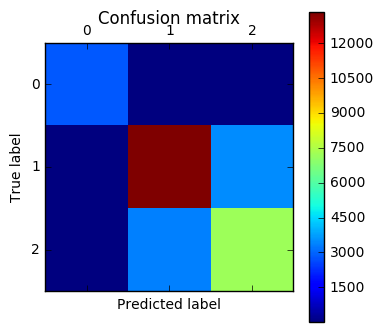

In [172]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### Less improvement than leaving formation in, but a fraction of a percent (0.08%) better than the basic model

### Throw the kitchen sink at the data and see if any other models show promise

In [176]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "Gradient Boosting", "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    GradientBoostingClassifier(),
    LogisticRegression()]


In [186]:
def get_scores(model, X_train, X_test, y_train, y_test, labels):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), \
           precision_score(y_test, y_predict, average='weighted', labels=labels), \
           recall_score(y_test, y_predict, average='weighted', labels=labels)

In [178]:
# prep the data
pbp = prep(pbp_train_raw.copy())

# split the class from the values
y = pbp['Play']
X = pbp.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [185]:
labels = gbc_cw.classes_

In [ ]:
# try out each of the classifiers
for name, clf in zip(names, classifiers):
    print name, ":", get_scores(clf, X_train, X_test, y_train, y_test, labels)

Nearest Neighbors : (0.61359670781893005, 0.61060484521224889, 0.61359670781893005)
Linear SVM :